# Example Usage of EQTransformer from seisbench
This notebook is mostly an uncommented version of the “03a_training_phasenet” notebook from the seisbench repository.

In [1]:
import seisbench.generate as sbg
import seisbench.models as sbm

from seisbench.data import WaveformDataset
from seisbench.models import EQTransformer
from seisbench.util import worker_seeding

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

import pandas as pd
from utils import preprocess


Load the 100Samples dataset from the EQTransformer repository but transformed into seisbench-compatible format.

Rename the label columns.

Perform (minimal) data augmentation.  I assume (but did not test) that `ChangeDtype` is necessary for the code to run; `ProbabilisticLabeller` provides the probability curves below, but I do not know how they are calculated.

In [2]:
batch_size = 1000 #
num_workers = 24  # The number of threads used for loading data

data = WaveformDataset("data/STEAD/example/seisbench")

train_loader, dev_loader, test_loader = preprocess(data, batch_size, num_workers)


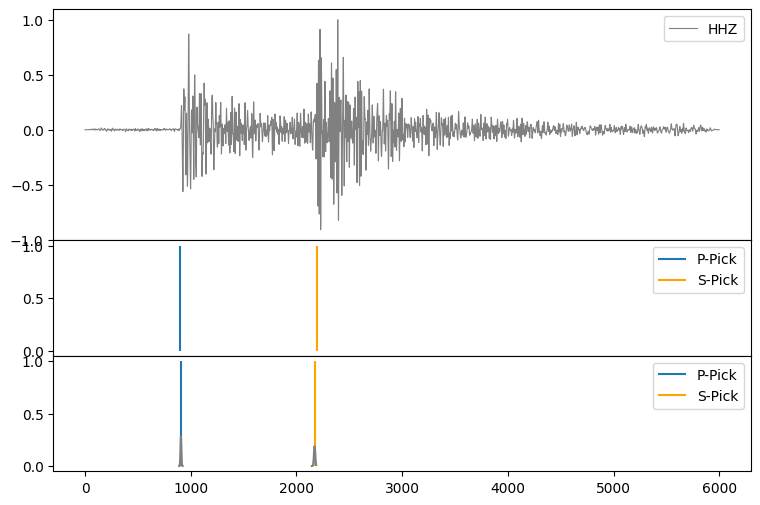

In [23]:
from swag.posteriors import SWAG

dataset = test_loader.dataset
# Get a random sample
random_index = int(np.random.random()*len(dataset))
sample = dataset[random_index]

fig = plt.figure(figsize=(9,6))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [2, 1, 1]})

axs[0].plot((sample["X"][0]/np.amax(sample["X"][0])).T, label='HHZ', linewidth=.8, color='gray')

# axs[1].plot(sample['detections'].T, color='green')
axs[1].vlines(np.argmax(sample['y'][0]), ymin=0, ymax=1, label='P-Pick')
axs[1].vlines(np.argmax(sample['y'][1]), ymin=0, ymax=1, label='S-Pick', color='orange')

weights = torch.load('.cache/swag-20.pt')['state_dict']
model = SWAG(
        EQTransformer,
        no_cov_mat=True,
        max_num_models=20,
        in_channels= 1
    )
model.load_state_dict(state_dict=weights, strict=False)
model.cuda()

model.sample(0.0)

preds_p = []
preds_s = []
preds_det = []

for i in range(100):
    output = model(torch.tensor(sample['X'][:1,:], device='cuda').unsqueeze(0))
    preds_p.append(np.argmax(output[1].detach().cpu().numpy()[0]))
    preds_s.append(np.argmax(output[2].detach().cpu().numpy()[0]))
    preds_det.append(output[0].detach().cpu().numpy()[0])

preds_p = np.array(preds_p)
preds_s = np.array(preds_s)
preds_det = np.array(preds_det)

p_pick_mean = np.mean(preds_p)
p_pick_std = np.std(preds_p)
s_pick_mean = np.mean(preds_s)
s_pick_std = np.std(preds_s)
det_mean = np.mean(np.array(preds_det), axis=0)

from scipy.stats import norm


# axs[2].plot(det_mean.T, color='green', label='Detection')
axs[2].vlines(p_pick_mean, ymin=0, ymax=1, label='P-Pick')
x_axis = np.arange(int(p_pick_mean-4*p_pick_std),int(p_pick_mean+4*p_pick_std),1)
axs[2].plot(x_axis, 3*norm.pdf(x_axis, p_pick_mean, p_pick_std), color='gray')
axs[2].vlines(s_pick_mean, ymin=0, ymax=1, label='S-Pick', color='orange')
x_axis = np.arange(int(s_pick_mean-4*s_pick_std),int(s_pick_mean+4*p_pick_std),1)
axs[2].plot(x_axis, 3*norm.pdf(x_axis, s_pick_mean, s_pick_std), color='gray')

for ax in axs:
    ax.legend()


In [33]:
print(preds_p)


[905 904 900 904 907 908 902 908 905 913 904 900 906 906 906 904 913 905
 902 901 908 906 910 902 906 908 912 906 914 907 916 904 908 902 907 902
 906 908 909 909 902 914 906 904 906 907 906 914 910 912 905 915 908 906
 906 904 904 912 905 905 902 912 909 903 908 910 912 909 914 909 920 907
 895 906 906 906 903 910 906 913 911 913 904 901 901 902 908 905 912 906
 904 912 904 911 902 913 902 906 914 912]


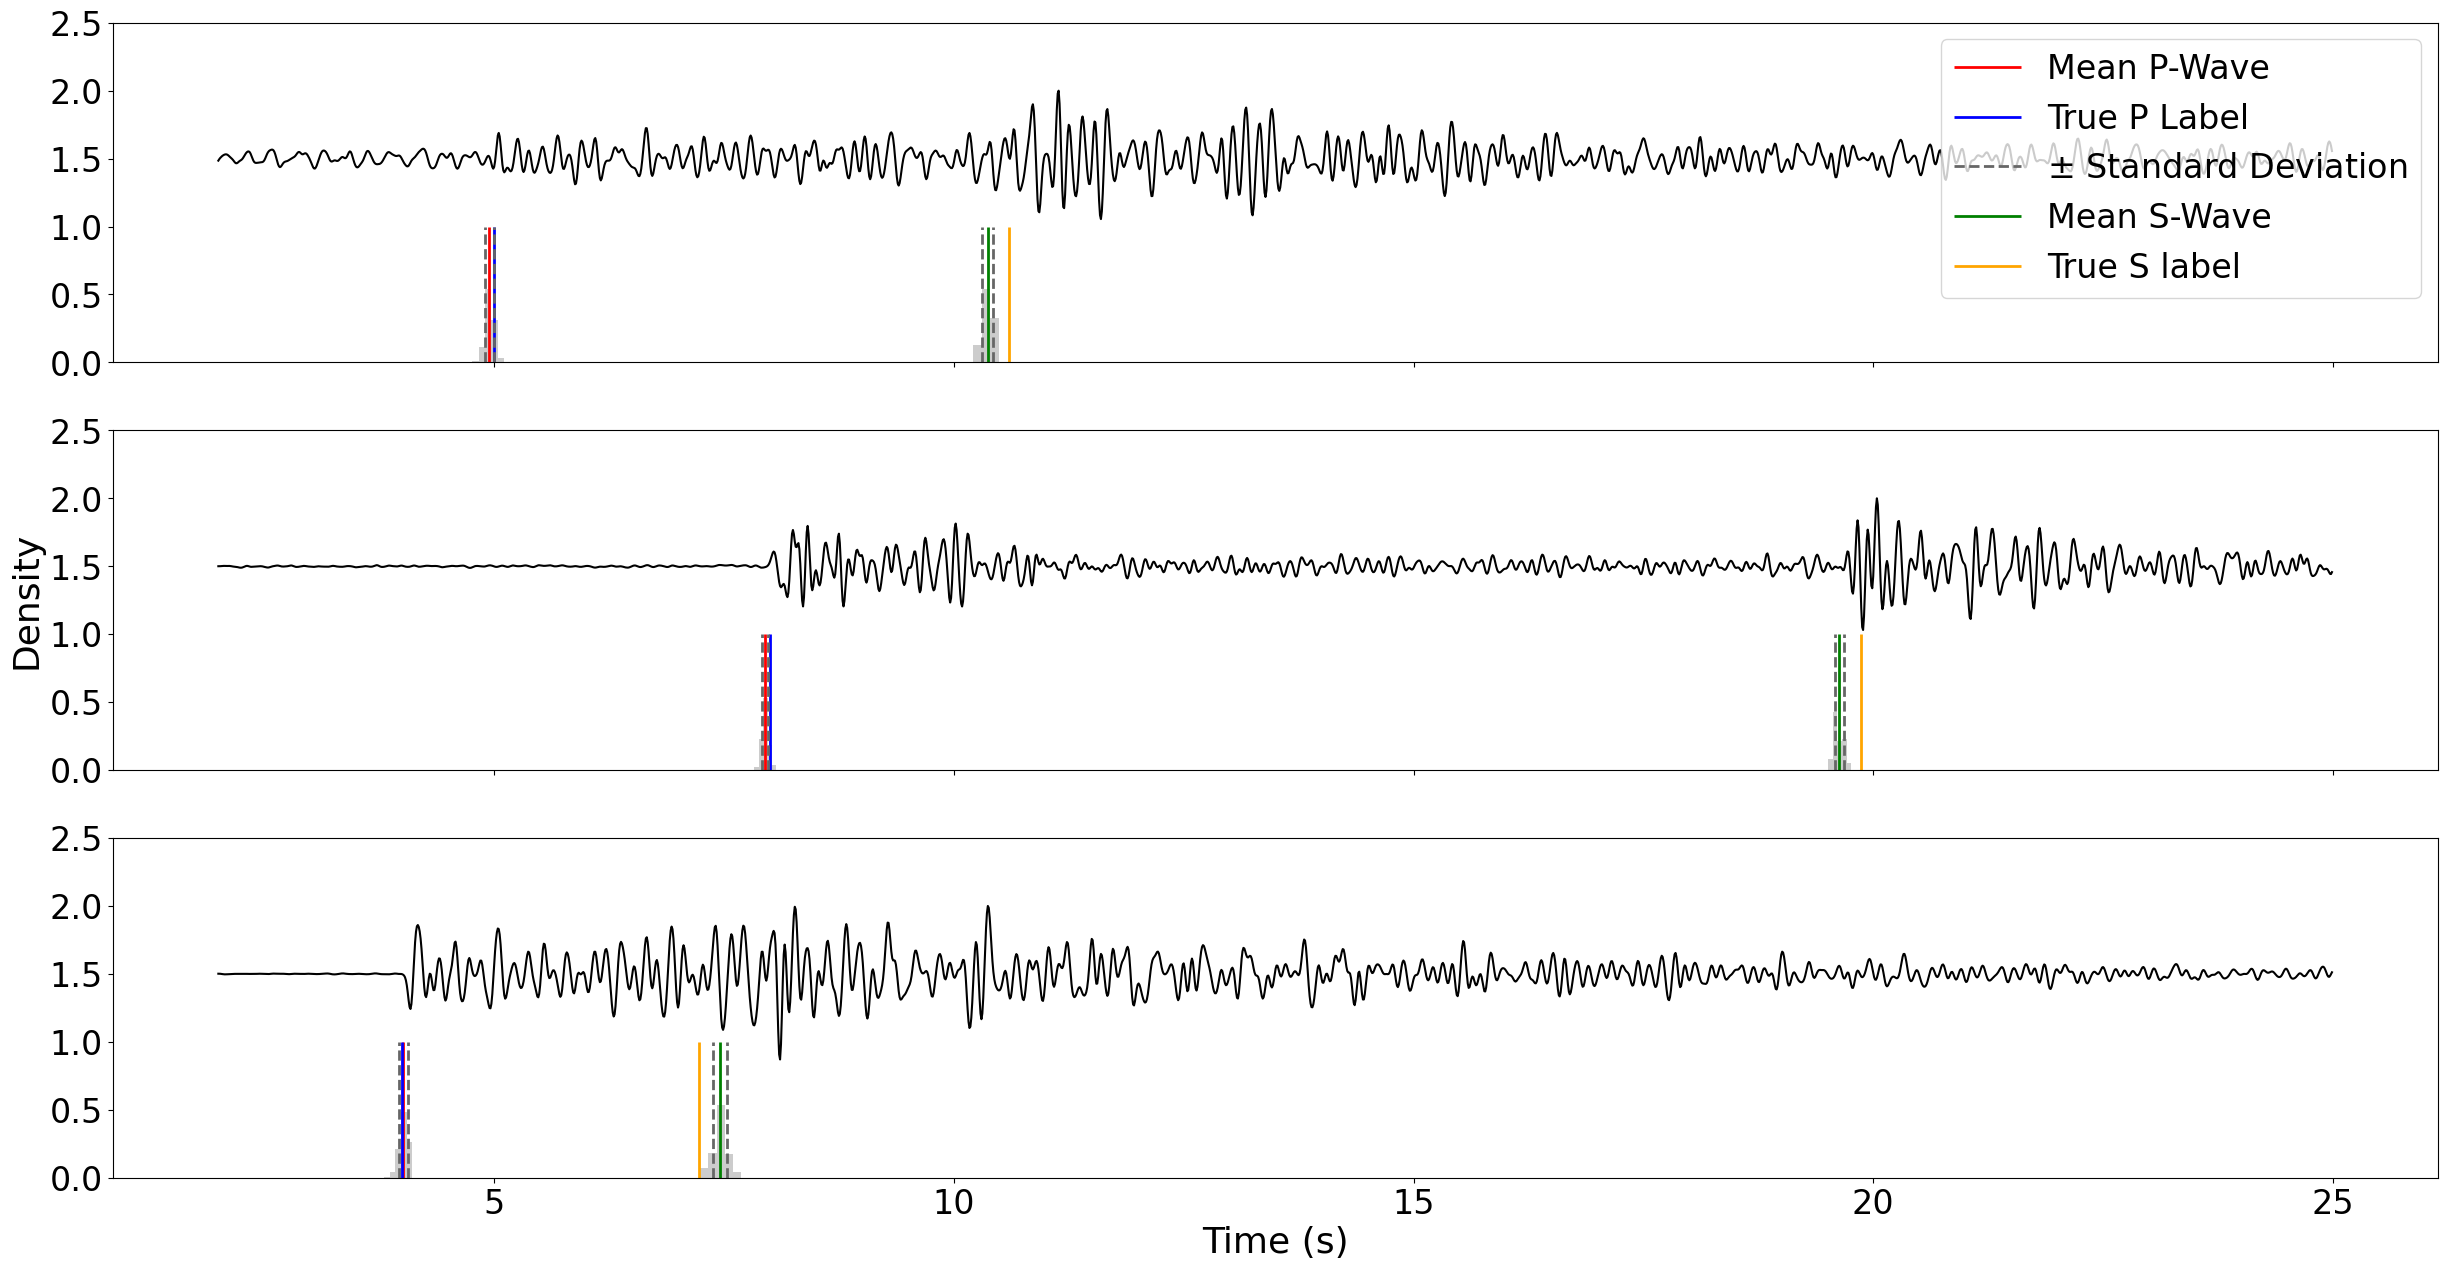

In [100]:
from swag.posteriors import SWAG

dataset = test_loader.dataset

# Load model
weights = torch.load('.cache/swag-20.pt')['state_dict']
model = SWAG(
        EQTransformer,
        no_cov_mat=True,
        max_num_models=20,
        in_channels= 1
    )
model.load_state_dict(state_dict=weights, strict=False)
model.cuda()

model.sample(0.0)

# Creating one plot with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(30, 15), sharex=True)

c = 0

for ax in axs:

    # Get a random sample
    random_index = int(np.random.random()*len(dataset))
    sample = dataset[random_index]

    preds_p = []
    preds_s = []
    preds_det = []

    # Predict
    for i in range(200):
        output = model(torch.tensor(sample['X'][:1,:], device='cuda').unsqueeze(0))
        preds_p.append(np.argmax(output[1].detach().cpu().numpy()[0]))
        preds_s.append(np.argmax(output[2].detach().cpu().numpy()[0]))
        preds_det.append(output[0].detach().cpu().numpy()[0])

    preds_p = np.array(preds_p)
    preds_s = np.array(preds_s)
    preds_det = np.array(preds_det)

    min_val = 200
    max_val = 2500



    # Plotting the wave
    x=np.array(list(range(0,6000,1)))
    ax.plot(x[min_val:max_val]/100, (sample["X"][0]/np.amax(sample["X"][0])/2).T[min_val:max_val] + 1.5, 'k')
    if c == 2: ax.set_xlabel('Time (s)', fontsize=26)
    if c==1: ax.set_ylabel('Density', fontsize=26)
    ax.tick_params(axis='both', which='major', labelsize=24)

    # Plotting the vertical lines for MAP and true label
    map_value = np.mean(preds_p)/100
    true_label = np.argmax(sample['y'][0])/100
    stdP = np.std(preds_p/100)
    ax.vlines(map_value, ymax=1, ymin=0, colors="r", label="Mean P-Wave", linewidth=2)
    ax.vlines(true_label, ymax=1, ymin=0, colors="b", label="True P Label", linewidth=2)
    ax.vlines([map_value + stdP, map_value - stdP], ymax=1, ymin=0, colors="0.4", label="$\pm$ Standard Deviation", linewidth=2, linestyles="--")

    map_value = np.mean(preds_s)/100
    true_label = np.argmax(sample['y'][1])/100
    stdS = np.std(preds_s/100)
    ax.vlines(map_value, ymax=1, ymin=0, colors="g", label="Mean S-Wave", linewidth=2)
    ax.vlines(true_label, ymax=1, ymin=0, colors="orange", label="True S label", linewidth=2)
    ax.vlines([map_value + stdS, map_value - stdS], ymax=1, ymin=0, colors="0.4", linewidth=2, linestyles="--")

    # Plotting the histogram
    n, bins, rects = ax.hist(preds_p/100, bins=5, alpha=0.4, color='gray')
    for r in rects:
        r.set_height(r.get_height()/preds_p.shape[0])
    n, bins, rects = ax.hist(preds_s/100, bins=5, alpha=0.4, color='gray')
    for r in rects:
        r.set_height(r.get_height()/preds_p.shape[0])

    # Adding legend
    if c == 0: ax.legend(fontsize=24)
    c += 1

    ax.set_ylim(0,2.5)

# Adjusting layout
plt.savefig("SwagResult.png")
# plt.show()


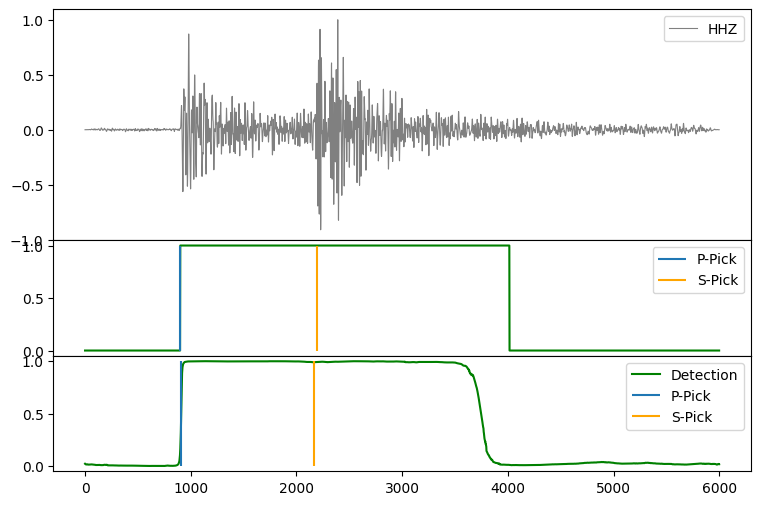

In [ ]:
from swag.posteriors import SWAG

dataset = test_loader.dataset
# Get a random sample
random_index = int(np.random.random()*len(dataset))
sample = dataset[random_index]

fig = plt.figure(figsize=(9,6))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [2, 1, 1]})

axs[0].plot((sample["X"][0]/np.amax(sample["X"][0])).T, label='HHZ', linewidth=.8, color='gray')

axs[1].plot(sample['detections'].T, color='green')
axs[1].vlines(np.argmax(sample['y'][0]), ymin=0, ymax=1, label='P-Pick')
axs[1].vlines(np.argmax(sample['y'][1]), ymin=0, ymax=1, label='S-Pick', color='orange')

weights = torch.load('.cache/checkpoint-20.pt')['state_dict']
model = EQTransformer(in_channels= 1)


model.load_state_dict(state_dict=weights, strict=False)
model.cuda()

outputs = model(torch.tensor(sample['X'][:1,:], device='cuda').unsqueeze(0))
pred = torch.stack(outputs, dim=1).detach().cpu().numpy()[0]

pred_rearanged = np.empty(pred.shape)
pred_rearanged[0] = pred[1]
pred_rearanged[1] = pred[2]
pred_rearanged[2] = pred[0]

p_pick = np.argmax(pred_rearanged[0])
s_pick = np.argmax(pred_rearanged[1])

# axs[2].plot(pred_rearanged.T, label=['P-wave','S-wave','Detection'])
axs[2].plot(pred_rearanged[2].T, color='green', label='Detection')
axs[2].vlines(p_pick, ymin=0, ymax=1, label='P-Pick')
axs[2].vlines(s_pick, ymin=0, ymax=1, label='S-Pick', color='orange')

for ax in axs:
    ax.legend()
